<a href="https://colab.research.google.com/github/Yash-10/Higgs-Classification/blob/main/HiggsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz

--2021-06-01 19:07:20--  https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816407858 (2.6G) [application/x-httpd-php]
Saving to: ‘HIGGS.csv.gz’

HIGGS.csv.gz        100%[===================>]   2.62G  37.5MB/s    in 39s     

2021-06-01 19:07:59 (69.6 MB/s) - ‘HIGGS.csv.gz’ saved [2816407858/2816407858]



In [2]:
!gzip -d HIGGS.csv.gz

In [3]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns

In [4]:
data_ = pd.read_csv('HIGGS.csv') # Read data from csv to a data frame

In [5]:
data_

,1.000000000000000000e+00,8.692932128906250000e-01,-6.350818276405334473e-01,2.256902605295181274e-01,3.274700641632080078e-01,-6.899932026863098145e-01,7.542022466659545898e-01,-2.485731393098831177e-01,-1.092063903808593750e+00,0.000000000000000000e+00,1.374992132186889648e+00,-6.536741852760314941e-01,9.303491115570068359e-01,1.107436060905456543e+00,1.138904333114624023e+00,-1.578198313713073730e+00,-1.046985387802124023e+00,0.000000000000000000e+00.1,6.579295396804809570e-01,-1.045456994324922562e-02,-4.576716944575309753e-02,3.101961374282836914e+00,1.353760004043579102e+00,9.795631170272827148e-01,9.780761599540710449e-01,9.200048446655273438e-01,7.216574549674987793e-01,9.887509346008300781e-01,8.766783475875854492e-01
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,1.858587,1.131711,-0.561694,0.000000,0.961000,0.671026,-0.178822,0.000000,1.177604,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,1.002570,-0.636189,-0.367500,0.000000,0.650326,0.511733,-0.182705,0.000000,1.427826,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,1.345027,0.993776,-1.298508,2.214872,1.252707,1.465673,1.262483,0.000000,0.419634,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,0.733136,0.356554,0.354436,2.214872,0.618363,-0.092672,-0.997614,0.000000,0.845596,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [6]:
print(f"No. of columns: {len(data_.columns)}\nNo. of rows: {len(data_.index)}")

No. of columns: 29
No. of rows: 10999999


In [7]:
column_names = "lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb"
columns = column_names.split(",")

In [8]:
# Column 2 - 22: Kinematic Properties (Low Level features)
# Column 23 - 29: Functions of above 21 features (High Level features) 
data_.columns = ['label'] + columns
data_

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,1.858587,1.131711,-0.561694,0.000000,0.961000,0.671026,-0.178822,0.000000,1.177604,-0.097068,1.190680,3.101961,0.822136,0.766772,1.002191,1.061233,0.837004,0.860472,0.772484
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,1.002570,-0.636189,-0.367500,0.000000,0.650326,0.511733,-0.182705,0.000000,1.427826,-0.216995,1.049177,3.101961,0.826829,0.989809,1.029104,1.199679,0.891481,0.938490,0.865269
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,1.345027,0.993776,-1.298508,2.214872,1.252707,1.465673,1.262483,0.000000,0.419634,1.585235,1.713962,0.000000,0.337374,0.845208,0.987610,0.883422,1.888438,1.153766,0.931279
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,0.733136,0.356554,0.354436,2.214872,0.618363,-0.092672,-0.997614,0.000000,0.845596,1.399515,-1.313189,0.000000,0.838842,0.882890,1.201380,0.939216,0.339705,0.759070,0.719119


In [9]:
drop_cols = data_.columns[-7:]
data_ = data_.drop(columns=list(drop_cols))

In [10]:
data_

,label,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10999994,1.0,1.159912,1.013847,0.108615,1.495524,-0.537545,2.342396,-0.839740,1.320683,0.000000,1.858587,1.131711,-0.561694,0.000000,0.961000,0.671026,-0.178822,0.000000,1.177604,-0.097068,1.190680,3.101961
10999995,1.0,0.618388,-1.012982,1.110139,0.941023,-0.379199,1.004656,0.348535,-1.678593,2.173076,1.002570,-0.636189,-0.367500,0.000000,0.650326,0.511733,-0.182705,0.000000,1.427826,-0.216995,1.049177,3.101961
10999996,1.0,0.700559,0.774251,1.520182,0.847112,0.211230,1.095531,0.052457,0.024553,2.173076,1.345027,0.993776,-1.298508,2.214872,1.252707,1.465673,1.262483,0.000000,0.419634,1.585235,1.713962,0.000000
10999997,0.0,1.178030,0.117796,-1.276980,1.864457,-0.584370,0.998519,-1.264549,1.276333,0.000000,0.733136,0.356554,0.354436,2.214872,0.618363,-0.092672,-0.997614,0.000000,0.845596,1.399515,-1.313189,0.000000


In [11]:
data_corr = data_.drop(['label'], axis=1).corr()
print(data_corr)

                           lepton pT   lepton eta  ...   jet 4 phi   jet 4 b-tag
lepton pT                   1.000000    -0.000153  ...   -0.000047      0.000139
 lepton eta                -0.000153     1.000000  ...    0.000301     -0.000146
 lepton phi                -0.000175     0.000418  ...   -0.065012     -0.000227
 missing energy magnitude  -0.139528    -0.000438  ...   -0.000165      0.009673
 missing energy phi         0.000232     0.000161  ...   -0.038633      0.000204
 jet 1 pt                   0.165798    -0.000396  ...   -0.000173     -0.005552
 jet 1 eta                 -0.000135     0.264797  ...   -0.000280     -0.000070
 jet 1 phi                 -0.000335    -0.000187  ...   -0.101777      0.000275
 jet 1 b-tag               -0.006265     0.000275  ...   -0.000275     -0.234233
 jet 2 pt                   0.004612     0.000123  ...   -0.000107     -0.027348
 jet 2 eta                  0.000031     0.264615  ...   -0.000217     -0.000493
 jet 2 phi                  

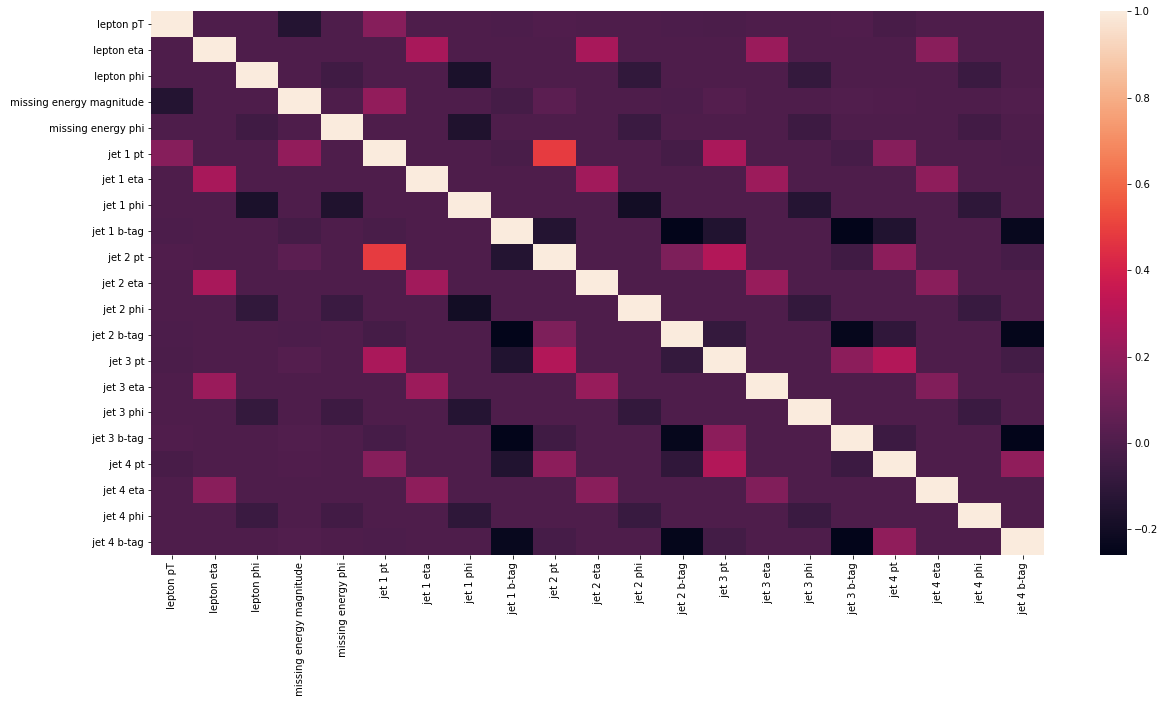

In [12]:
plt.figure(figsize=(20, 10))
sns.heatmap(data_corr)

Text(0, 0.5, 'jet 2 pt')

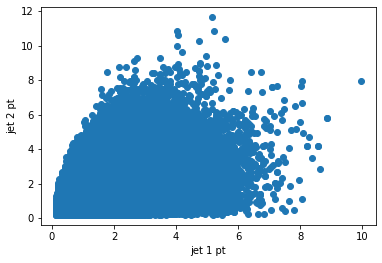

In [13]:
plt.scatter(data_[' jet 1 pt'], data_[' jet 2 pt'])
plt.xlabel('jet 1 pt')
plt.ylabel('jet 2 pt')

In [14]:
device = torch.device('cuda:0') if torch.cuda.is_available() else 'cpu'

In [15]:
# Custom class creation - Preparing data

class HIGGSDataset(Dataset):
  def __init__(self, csv_file, root):
    self.data_ = pd.read_csv(csv_file)
    self.root = root

  def __len__(self):
    return len(self.data_)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist() # Converts a torch tensor to a python list
    class_0_1 = self.data_.iloc[idx, 1] # 0 for non-reduced csv file, 1 for reduced one. Change this to be dynamic
    values = self.data_.iloc[idx, 1:]
    data_ = np.array(values)
    data_ = data_.astype('float').reshape(-1, 2)
    sample = {'class': class_0_1, 'data': data_}

    return sample

In [18]:
# Create reduced csv file
data_[:10000].to_csv("Higgs_reduced.csv")

In [19]:
# Instantiating dataset
Higgs_dataset = HIGGSDataset('Higgs_reduced.csv', '/content/') # Using '/content/' for Google Colab

In [59]:
batch_size = 16 # No. of samples to load per batch
shuffle = True # Shuffle to remove any bias in data
dataset_size = len(Higgs_dataset)
val_split = 0.2
split = int(np.floor(val_split * dataset_size))
indices = list(range(dataset_size))
np.random.shuffle(indices)

# Split into train and valid sets
train_indices, valid_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

train_loader = DataLoader(Higgs_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(Higgs_dataset, batch_size=batch_size, sampler=valid_sampler)

In [60]:
# Creating a Sequential model

# Higgs_model = nn.Sequential(nn.Linear(22, 14),
#                             nn.ReLU(),
#                             nn.Linear(14, 7),
#                             nn.ReLU(),
#                             nn.Linear(7, 1),
#                             nn.Sigmoid())

class Higgs_Model(nn.Module):
    def __init__(self):
        super(Higgs_Model, self).__init__()
  
        self.fc1 = nn.Linear(22, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.25)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = x.squeeze()
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        x = self.sig(x)
        return x

In [61]:
Higgs_model = Higgs_Model()

In [62]:
criterion = nn.BCELoss()
optimizer = optim.Adam(params=Higgs_model.parameters(), lr=0.0001)

In [63]:
print(Higgs_model)

Higgs_Model(
  (fc1): Linear(in_features=22, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=16, bias=True)
  (fc5): Linear(in_features=16, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (sig): Sigmoid()
)


In [64]:
# Training

n_epochs = 20

train_losses = []
valid_losses = []
valid_loss_min = np.inf

for epoch in range(1, n_epochs+1):
  train_loss = 0
  valid_loss = 0

  # Training
  Higgs_model.train()
  for i, batch in enumerate(train_loader, 0):
    #print('Training going on...')
    data = batch['data']
    data = data.view(data.shape[0], -1)
    target = batch['class']
    target = target.type(torch.LongTensor)
    #data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = Higgs_model(data.float())
    loss = criterion(output, target.float().unsqueeze(1))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    train_loss += loss.item() * data.size(0)
  
  # Validation
  Higgs_model.eval()
  for i, batch in enumerate(validation_loader, 0):
    data = batch['data']
    data = data.view(data.shape[0], -1)
    target = batch['class']
    output = Higgs_model(data.float())
    loss = criterion(output, target.float().unsqueeze(1))
    valid_loss += loss.item() * data.size(0)

  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(validation_loader.sampler)
  
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'Epoch: {epoch}',
        f'Training Loss: {train_loss}',
        f'Valid Loss: {valid_loss}')
  
  if valid_loss < valid_loss_min:
    print(f'Validation Loss decreased: {valid_loss_min} --> {valid_loss}. Saving model...')
    torch.save(Higgs_model.state_dict(), 'higgs_model.pt')
    valid_loss_min = valid_loss

Epoch: 1 Training Loss: 0.6885581774711609 Valid Loss: 0.681312846660614
Validation Loss decreased: inf --> 0.681312846660614. Saving model...
Epoch: 2 Training Loss: 0.6626684259176254 Valid Loss: 0.6006825208663941
Validation Loss decreased: 0.681312846660614 --> 0.6006825208663941. Saving model...
Epoch: 3 Training Loss: 0.5563574606776237 Valid Loss: 0.36335202169418335
Validation Loss decreased: 0.6006825208663941 --> 0.36335202169418335. Saving model...
Epoch: 4 Training Loss: 0.40707245326042174 Valid Loss: 0.19347544205188752
Validation Loss decreased: 0.36335202169418335 --> 0.19347544205188752. Saving model...
Epoch: 5 Training Loss: 0.36967670542001724 Valid Loss: 0.14956523501873017
Validation Loss decreased: 0.19347544205188752 --> 0.14956523501873017. Saving model...
Epoch: 6 Training Loss: 0.35564379385113715 Valid Loss: 0.14771942618489264
Validation Loss decreased: 0.14956523501873017 --> 0.14771942618489264. Saving model...
Epoch: 7 Training Loss: 0.3437992573827505 V

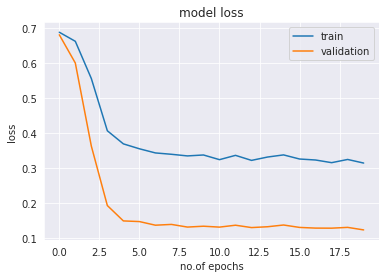

In [65]:
# Plot loss

plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('no.of epochs')
plt.legend(['train', 'validation'], loc='best')
plt.show()

In [66]:
# Load the model

state_dict = torch.load('/content/higgs_model.pt')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias', 'fc5.weight', 'fc5.bias'])


In [87]:
# Create testting data
test_data = data_[10000:20000]
test_data.to_csv("TEST_Higgs_reduced.csv")
test_higgs_dataset = HIGGSDataset('TEST_Higgs_reduced.csv', '/content/')
test_loader = DataLoader(test_higgs_dataset, batch_size=batch_size)

def check_accuracy(loader, model):
  # Reference: https://discuss.pytorch.org/t/how-to-find-test-accuracy-after-training/88962/3
  accuracy = 0
  num_correct = 0
  num_samples = 0
  model.eval()
  
  with torch.no_grad():
    for i, batch in enumerate(loader, 0):
      data = batch['data']
      data = data.view(data.shape[0], -1)
      target = batch['class']
      # x = x.to(device=device)
      # y = y.to(device=device)
      
      scores = model(data.float())
      _, predictions = scores.max(1)
      num_correct += (predictions == target).sum()
      num_samples += predictions.size(0)
      
      acc = float(num_correct)/float(num_samples)*100
      print(f'Got {num_correct} / {num_samples} with accuracy {acc}') 
      accuracy += acc
  print("\n")
  print(f"Test Accuracy: {accuracy/len(loader)}")
  
  model.train()

  return predictions, target

test_higgs_model = Higgs_Model()
test_higgs_model.load_state_dict(state_dict)
predictions, target = check_accuracy(test_loader, test_higgs_model)

Got 12 / 16 with accuracy 75.0
Got 19 / 32 with accuracy 59.375
Got 26 / 48 with accuracy 54.166666666666664
Got 37 / 64 with accuracy 57.8125
Got 45 / 80 with accuracy 56.25
Got 55 / 96 with accuracy 57.291666666666664
Got 60 / 112 with accuracy 53.57142857142857
Got 69 / 128 with accuracy 53.90625
Got 74 / 144 with accuracy 51.388888888888886
Got 82 / 160 with accuracy 51.24999999999999
Got 87 / 176 with accuracy 49.43181818181818
Got 93 / 192 with accuracy 48.4375
Got 99 / 208 with accuracy 47.59615384615385
Got 107 / 224 with accuracy 47.767857142857146
Got 117 / 240 with accuracy 48.75
Got 125 / 256 with accuracy 48.828125
Got 138 / 272 with accuracy 50.73529411764706
Got 146 / 288 with accuracy 50.69444444444444
Got 157 / 304 with accuracy 51.64473684210527
Got 161 / 320 with accuracy 50.31250000000001
Got 170 / 336 with accuracy 50.595238095238095
Got 178 / 352 with accuracy 50.56818181818182
Got 186 / 368 with accuracy 50.54347826086957
Got 195 / 384 with accuracy 50.78125
Got 

In [88]:
!pip install plot-metric

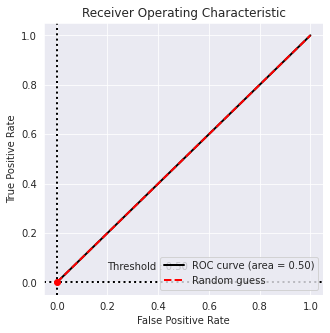

In [89]:
from plot_metric.functions import BinaryClassification
# Visualisation with plot_metric
bc = BinaryClassification(target, predictions, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(5,5))
bc.plot_roc_curve()
plt.show()